In [1]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
import pandas as pd
pd.__version__

'0.24.2'

In [3]:
import sklearn
sklearn.__version__

'0.24.2'

In [4]:
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [5]:
# itu dataset path
dataset_path = '~/code/itu-ml-challenge/csv/diff_dataset.csv'
testset_path = '~/code/itu-ml-challenge/csv/diff_testset.csv'

In [6]:
# read dataset
dataset = pd.read_csv(dataset_path, index_col=None, header=0)
testset = pd.read_csv(testset_path, index_col=None, header=0)
print(dataset.shape, testset.shape)

(1862, 661) (1681, 661)


In [7]:
# drop unnamed column

try:
    dataset.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
    testset.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
except Exception:
    print('aleardy deleted')

<AxesSubplot:>

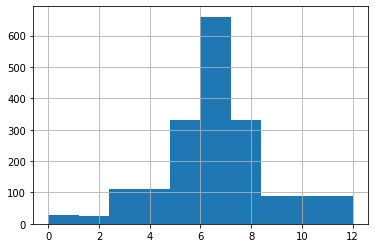

In [8]:
dataset['v_type_code'].hist()

In [9]:
# Delete the following states
# 0: ixnetwork-traffic-start
# 2: node-up
# 4: interface-up
# 6: tap-loss-stop
# 8: tap-delay-stop
# 10: ixnetwork-bgp-injection-stop
# 12: ixnetwork-bgp-hijacking-stop
data_drop_index = dataset[dataset['v_type_code'] % 2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] % 2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)


# Try to combine 5 and 7 into one type.
dataset['v_type_code'] = dataset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)
testset['v_type_code'] = testset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)


print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

dataset:
(930, 659)
testset:
(840, 659)


In [10]:
# train test split
column = dataset.columns
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1770, 658) (1770,)
(930, 658) (930,)
(840, 658) (840,)


In [11]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)

# Define models

In [33]:
# Decision tree

def decision_tree(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)

    dt.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = dt.predict(X_test)

    current_time = time.time()

    print("DT Accuracy: %.2f" % accuracy_score(y_test, y_pred))

    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix dt:')
        print(cm)
        print('classification report dt:')
        print(classification_report(y_test, y_pred))


# random forest
def random_forest(X_train, y_train, X_test, y_test, show=False, estimators=100):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=estimators, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()
    print("n_estimators: %d" % estimators)
    print("RF Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))


# XGBoost
def xgboost(X_train, y_train, X_test, y_test, show=False, estimators=100):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=estimators, n_jobs=-1, objective='multi:softmax', num_class=5, random_state=0)

    xgb.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = xgb.predict(X_test)

    current_time = time.time()

    print("n_estimators: %d" % estimators)
    print("XGBOOST Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix xgb:')
        print(cm)
        print('classification report xgb:')
        print(classification_report(y_test, y_pred))


# MLP
def mlp(std_X_train, y_train, std_X_test, y_test, show=False):
    last_time = time.time()
    mlp = MLPClassifier(solver='sgd', activation='relu', alpha=1e-4, hidden_layer_sizes=(200, 200, 200, 200),
                        random_state=1, max_iter=10000, verbose=0, learning_rate_init=.1)
    mlp.fit(std_X_train, y_train)
    middle_time = time.time()
    y_pred = mlp.predict(std_X_test)
    current_time = time.time()
    print("MLP Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix MLP:')
        print(cm)
        print('classification report MLP:')
        print(classification_report(y_test, y_pred))


# SVM
def svm_cross_validation(X, y):
    model = svm.SVC(kernel='rbf', probability=True)
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=1)
    grid_search.fit(X, y)
    best_parameters = grid_search.best_estimator_.get_params()
    for para, val in list(best_parameters.items()):
        print(para, val)
    model = svm.SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)
    model.fit(X, y)
    return model


def train_svm(std_X_train, y_train, std_X_test, y_test, show=False):
    last_time = time.time()
    # model = svm_cross_validation(std_X_train, y_train.ravel())
    model = svm.SVC(kernel='rbf', C=10, gamma=0.001, probability=True)
    model.fit(std_X_train, y_train)
    middle_time = time.time()
    y_pred = model.predict(std_X_test)
    print("SVM Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    current_time = time.time()
    print("train time： {}".format(middle_time - last_time))
    if show:
        print("test time： {}".format(current_time - middle_time))
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix svm:')
        print(cm)
        print('classification report svm:')
        print(classification_report(y_test, y_pred))

# Load generated dataset

In [43]:
type3_ganset = pd.read_csv('./csv/all/diff_dataset_type11_3.csv', index_col=None, header=0)

In [44]:
type3_ganset.astype({'v_type_code': 'int32'}).dtypes

try:
    type3_ganset.drop(columns=['Unnamed: 0'], inplace=True)
    type3_ganset.drop(columns=['Unnamed: 0.1'], inplace=True)
except Exception:
    print('aleardy deleted')

print(type3_ganset.shape)

aleardy deleted
(223, 659)


In [45]:
type3_ganset.head()

,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/threads,p_/computes0/cpu_info/topology/sockets,p_/computes0/running_vms,...,v_/ports#link-tr-tr-a-1-x/metrics/network-outgoing-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_type_code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.001007,2.716733e+06,-0.052399,8250.534101,0.000029,4.125786e+06,-0.527300,9278.543515,-0.003813,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004083,1.748016e+07,0.336933,32520.542827,0.003475,1.309250e+07,0.314554,28574.244122,0.005038,11
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000494,4.763452e+06,0.017621,12265.296257,0.000581,6.119292e+06,0.202739,12940.121397,0.002176,11
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.007153,-5.365113e+06,-1.072318,-11193.335574,-0.008337,-4.829444e+06,1.294016,-10490.689698,0.006222,11
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006625,-8.984303e+06,1.002893,-14913.601224,0.006493,-6.622617e+06,1.674398,-13379.356863,0.007882,11


In [46]:
# if error
# type3_ganset['n_/devices/modules/Cisco-IOS-XE-platform-software-oper/cisco-platform-software/control-processes/control-process/per-core-stats/per-core-stat/sirq'] = 0

# type3_ganset['v_/devices#IntGW-02/metrics/disk-device-write-requests-rate'] = 0

if 'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/output-queue' not in type3_ganset.columns:
    type3_ganset['n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/output-queue'] = 0
if 'n_/devices/modules/Cisco-IOS-XE-platform-software-oper/cisco-platform-software/system-usages/system-usage/process-system-usages/process-system-usage/five-seconds' not in type3_ganset.columns:
    type3_ganset['n_/devices/modules/Cisco-IOS-XE-platform-software-oper/cisco-platform-software/system-usages/system-usage/process-system-usages/process-system-usage/five-seconds'] = 0
             

In [47]:
X_gan_type3 = type3_ganset[column[:-1]]
y_gan_type3 = type3_ganset[column[-1]]
print(X_gan_type3.shape, y_gan_type3.shape)

(223, 658) (223,)


In [48]:
rf = random_forest(X_train, y_train, X_test, y_test, show=True)

n_estimators: 100
RF Accuracy: 0.89
train time： 1.052321195602417
test time： 0.03581690788269043
confusion matrix rf:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   0   0 134  46]
 [  0   2   0  47 319]]
classification report rf:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.97      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       0.74      0.74      0.74       180
          57       0.87      0.87      0.87       368

    accuracy                           0.89       840
   macro avg       0.92      0.92      0.92       840
weighted avg       0.89      0.89      0.89       840



In [49]:
rf_gan_type3 = random_forest(X_train, y_train, X_gan_type3, y_gan_type3, show=True)

n_estimators: 100
RF Accuracy: 0.07
train time： 0.9417121410369873
test time： 0.01661968231201172
confusion matrix rf:
[[  1   0   0]
 [  0   0   0]
 [201   7  14]]
classification report rf:
              precision    recall  f1-score   support

           3       0.00      1.00      0.01         1
           9       0.00      0.00      0.00         0
          11       1.00      0.06      0.12       222

    accuracy                           0.07       223
   macro avg       0.33      0.35      0.04       223
weighted avg       1.00      0.07      0.12       223



/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
xgb_gan_type3 = xgboost(X_train, y_train, X_gan_type3, y_gan_type3, show=True)

n_estimators: 100
XGBOOST Accuracy: 0.28
train time： 8.982274055480957
test time： 0.017110109329223633
confusion matrix xgb:
[[ 0  0  0  0]
 [ 0  0  0  1]
 [28 50 63 81]
 [ 0  0  0  0]]
classification report xgb:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
          11       1.00      0.28      0.44       222
          57       0.00      0.00      0.00         0

    accuracy                           0.28       223
   macro avg       0.25      0.07      0.11       223
weighted avg       1.00      0.28      0.44       223



/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
decision_tree(X_train, y_train, X_gan_type3, y_gan_type3, show=True)

DT Accuracy: 0.15
train time： 0.38172483444213867
test time： 0.008200883865356445
confusion matrix dt:
[[ 0  0  0  0  0]
 [ 0  0  0  0  1]
 [ 0  0  0  0  0]
 [ 7 77 30 33 75]
 [ 0  0  0  0  0]]
classification report dt:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          11       1.00      0.15      0.26       222
          57       0.00      0.00      0.00         0

    accuracy                           0.15       223
   macro avg       0.20      0.03      0.05       223
weighted avg       1.00      0.15      0.26       223



/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# combine with original training dataset

In [26]:
dataset_new = pd.concat([dataset, type3_ganset], ignore_index=True, sort=False)
dataset_new = dataset_new.reset_index(drop=True)

In [27]:
dataset_new.head()

,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/threads,p_/computes0/cpu_info/topology/sockets,p_/computes0/running_vms,...,v_/ports#link-tr-tr-a-1-x/metrics/network-outgoing-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_type_code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000010,4332.0,0.880124,36.0,0.000333,4332.0,2.713499,36.0,-0.000637,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.016052,3986.0,0.933730,35.0,0.016481,3986.0,2.805528,35.0,-0.016620,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001333,4714.0,-0.046393,41.0,0.000471,4714.0,1.920622,41.0,-0.000124,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.099923,342.0,-12.543411,3.0,-0.116318,3568.0,-2.326906,32.0,-0.016621,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000207,854.0,-11.301755,7.0,-0.116844,740.0,-11.397061,6.0,-0.117156,1


<AxesSubplot:>

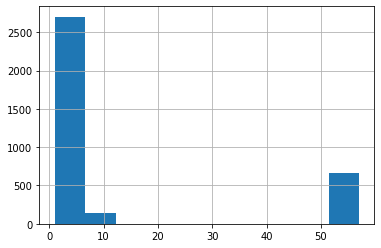

In [29]:
dataset_new['v_type_code'].hist()

In [30]:
X_train_new = dataset_new[column[:-1]]
X_test = testset[column[:-1]]
y_train_new = dataset_new[column[-1]]
y_test = testset[column[-1]]

In [33]:
decision_tree(X_train, y_train, X_test, y_test, show=True)

random_forest(X_train, y_train, X_test, y_test, show=True)

xgboost(X_train, y_train, X_test, y_test, show=True)

DT Accuracy: 0.82
train time： 0.3868710994720459
test time： 0.0051326751708984375
confusion matrix dt:
[[ 58   2   0   2   2]
 [  0  68   0   1   3]
 [  0   0 156   0   0]
 [  0   3   0 137  40]
 [  0   1   0  96 271]]
classification report dt:
              precision    recall  f1-score   support

           1       1.00      0.91      0.95        64
           3       0.92      0.94      0.93        72
           9       1.00      1.00      1.00       156
          11       0.58      0.76      0.66       180
          57       0.86      0.74      0.79       368

    accuracy                           0.82       840
   macro avg       0.87      0.87      0.87       840
weighted avg       0.84      0.82      0.83       840

n_estimators: 100
RF Accuracy: 0.89
train time： 0.9117257595062256
test time： 0.021978139877319336
confusion matrix rf:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   0   0 134  46]
 [  0   2   0  47 319]]
classification report rf:
    

In [32]:
decision_tree(X_train_new, y_train_new, X_test, y_test, show=True)

random_forest(X_train_new, y_train_new, X_test, y_test, show=True)

xgboost(X_train_new, y_train_new, X_test, y_test, show=True)

DT Accuracy: 0.83
train time： 1.1529390811920166
test time： 0.00518488883972168
confusion matrix dt:
[[ 52   5   0   1   6]
 [  2  59   1   3   7]
 [  0   0 156   0   0]
 [  1   1   0 130  48]
 [  0   9   0  55 304]]
classification report dt:
              precision    recall  f1-score   support

           1       0.95      0.81      0.87        64
           3       0.80      0.82      0.81        72
           9       0.99      1.00      1.00       156
          11       0.69      0.72      0.70       180
          57       0.83      0.83      0.83       368

    accuracy                           0.83       840
   macro avg       0.85      0.84      0.84       840
weighted avg       0.84      0.83      0.84       840

n_estimators: 100
RF Accuracy: 0.89
train time： 2.4824607372283936
test time： 0.022416353225708008
confusion matrix rf:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   1 155   0   0]
 [  0   0   0 132  48]
 [  0   2   0  43 323]]
classification report rf:
      